In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, 
roc_curve, precision_recall_curve,roc_auc_score,accuracy_score)
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler,SMOTE
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.filterwarnings('ignore',category=FutureWarning)
sns.set()
%matplotlib inline

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [67]:
data_dir ='../input/wayfair/'
test = pd.read_csv(data_dir + 'df_holdout_scholarjet.csv',index_col = 0)
train = pd.read_csv(data_dir + 'df_training_scholarjet.csv',index_col = 0)

In [68]:
test.head()

,cuid,roll_up,currentstatus,companytypegroup,team,customersource,accrole,num_employees,num_purchases_year,cost_purchases_year,...,percemailopenedyearsixty,percemailclickedone,percemailclickedthreeone,percemailclickedseventhree,percemailclickedthirtyseven,percemailclickedsixtythirty,percemailclickedyearsixty,currentapplicability,numemaillist,dayssinceenrollment
0,16838,Onboarding,Enrolled,Business,US,Internal Application,None,1,1to2,lessthan1,...,0.025806,0.0,0.0,0.0,0.021739,0.012821,0.032258,5.0,2.0,86
1,532175,Onboarding,Enrolled,Business,US,Search - Paid,None,6to10,None,None,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,3
2,532176,Onboarding,Enrolled,Business,US,Internal Application,None,11to50,3to5,1to5,...,0.036190,0.0,0.0,0.0,0.000000,0.000000,0.015238,8.0,4.0,13
3,532187,Onboarding,Enrolled,Business,US,Internal Application,Primary,None,None,None,...,1.000000,0.0,0.0,0.5,0.272727,0.250000,0.000000,NaN,NaN,10
4,16938,Onboarding,Enrolled,Trade,US,Internal Customer Scrape,Primary,None,None,None,...,0.049383,0.5,0.0,0.0,0.000000,0.043478,0.016461,5.0,2.0,42


In [70]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.9]

big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))

print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)
train

0 features are going to be dropped for being useless


,cuid,convert_30,revenue_30,roll_up,currentstatus,companytypegroup,customersource,accrole,num_employees,num_purchases_year,...,percemailopenedseventhree,percemailopenedthirtyseven,percemailopenedsixtythirty,percemailopenedyearsixty,percemailclickedthirtyseven,percemailclickedsixtythirty,percemailclickedyearsixty,currentapplicability,numemaillist,dayssinceenrollment
1,20,0,0.00,Onboarding,Active,Business,External Application,None,50plus,1to2,...,0.800000,0.809524,0.000000,0.000000,0.190476,0.000000,0.000000,3.000000,1.0,17
2,57,0,0.00,Onboarding,Active,Business,Internal Application,None,2to5,25plus,...,0.000000,0.080000,0.000000,0.020000,0.040000,0.000000,0.020000,3.000000,1.0,70
3,163,0,0.00,Onboarding,Active,Business,Internal Application,None,1,3to5,...,0.000000,0.113636,0.086207,0.106195,0.000000,0.000000,0.001770,13.000000,1.0,27
4,167,0,0.00,Onboarding,Enrolled,Business,Internal Customer Scrape,None,50plus,3to5,...,0.000000,1.000000,0.000000,0.100000,0.000000,0.000000,0.100000,NaN,NaN,25
5,168,0,0.00,Onboarding,Enrolled,Business,Gateway,None,6to10,11to25,...,0.050000,0.047619,0.058824,0.072072,0.009524,0.016807,0.003465,8.333333,3.0,33
9,215,0,0.00,Onboarding,Enrolled,Business,Internal Application,None,None,None,...,0.000000,0.166667,0.206897,0.349112,0.000000,0.034483,0.059172,1.000000,1.0,2
12,285,0,0.00,Onboarding,Enrolled,Business,Internal Customer Scrape,None,None,None,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.111111,0.000000,1.0,99
14,363,1,323.97,Onboarding,Active,Business,External Application,None,1,25plus,...,0.000000,0.223529,0.335106,0.222433,0.023529,0.015957,0.071293,8.333333,3.0,42
15,401,0,0.00,Onboarding,Active,Business,Internal Application,None,None,None,...,0.250000,0.200000,0.157895,0.123457,0.072727,0.052632,0.012346,4.000000,2.0,35
17,421,0,0.00,Onboarding,Enrolled,Business,Internal Application,Primary,None,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.0,0


In [71]:
for col in tqdm_notebook(train.columns): 
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values)) 

In [73]:
test.head()

,cuid,roll_up,currentstatus,companytypegroup,customersource,accrole,num_employees,num_purchases_year,cost_purchases_year,enrollmentmethod,...,percemailopenedseventhree,percemailopenedthirtyseven,percemailopenedsixtythirty,percemailopenedyearsixty,percemailclickedthirtyseven,percemailclickedsixtythirty,percemailclickedyearsixty,currentapplicability,numemaillist,dayssinceenrollment
0,16838,0,1,0,7,0,0,1,5,0,...,0.0,0.021739,0.012821,0.025806,0.021739,0.012821,0.032258,5.0,2.0,86
1,532175,0,1,0,13,0,4,5,4,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,3
2,532176,0,1,0,7,0,1,3,1,0,...,0.0,0.016949,0.016667,0.036190,0.000000,0.000000,0.015238,8.0,4.0,13
3,532187,0,1,0,7,2,5,5,4,5,...,0.5,1.000000,0.750000,1.000000,0.272727,0.250000,0.000000,NaN,NaN,10
4,16938,0,1,1,8,2,5,5,4,5,...,0.0,0.153846,0.043478,0.049383,0.000000,0.043478,0.016461,5.0,2.0,42


In [74]:
X_c = train.drop(['cuid', 'convert_30', 'revenue_30'], axis=1)
y_c = train['convert_30']
X_c.fillna(-999, inplace=True)
test = test.drop(['cuid'], axis=1)

Lightbgm

In [ ]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

clf = lgb.LGBMClassifier(**params)
rfe = RFECV(estimator=clf, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)

In [ ]:
rfe.fit(X_c, y_c)

In [ ]:
print('Optimal number of features:', rfe.n_features_)

In [ ]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [ ]:
for col in X_c.columns[rfe.ranking_ == 1]:
    print(col)

Xgb

In [ ]:
params_x = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'max_depth': 10,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
            'eval_metric': 'auc',
          "verbosity": 1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
clfx = xgb.XGBClassifier(**params_x)
rfe2 = RFECV(estimator=clfx, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)


In [ ]:
rfe2.fit(X_c, y_c)

In [ ]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe2.grid_scores_) + 1), rfe2.grid_scores_)
plt.show()

Catboost

In [ ]:
from catboost import CatBoostClassifier
clfc = CatBoostClassifier()
rfe3 = RFECV(estimator=clfc, step=10, cv=KFold(n_splits=5, shuffle=False), scoring='roc_auc', verbose=2)
rfe3.fit(X_c, y_c)

In [ ]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe3.grid_scores_) + 1), rfe3.grid_scores_)
plt.show()

In [ ]:
alist = list(X_c.columns[rfe.ranking_ == 1])
blist = list(X_c.columns[rfe2.ranking_ == 1])
clist = list(X_c.columns[rfe3.ranking_ == 1])

useful_features = list(set(alist+blist+clist))
print(useful_features)

In [25]:
useful_features = ['numordersixtythirty', 'percsecondsinbound', 'percdirtythirty', 'numatcthirtyseven', 'numorderthreeone', 'sumatcprice', 'currentstatus', 'numatcyearsixty', 'percemailclickedthirtyseven', 'numstores', 'numideaboardyearsixty', 'totalcalldurationthirtyseven', 'numtotalpageviewsthirtyseven', 'pospercentage', 'numatcseventhree', 'percentresolved', 'accrole', 'numideaboardseventhree', 'numvisitseventhree', 'numvisitthirtyseven', 'avgatcprice', 'percemailopenedsixtythirty', 'numinf', 'numskusviewedseventhree', 'numsearchtermsyearsixty', 'avgpricesixtythirty', 'totalrev', 'sumrevsixtythirty', 'numskusviewedone', 'numselforder', 'numinfphone', 'cuidshare', 'avgpriceyearsixty', 'numtotalpageviewsthreeone', 'totalcalldurationyearsixty', 'numinfconnect', 'numtotalpageviewsseventhree', 'numcallsthirtyseven', 'numloggedinthirtyseven', 'dayssincelastvisit', 'numsecondsonsitethreeone', 'sumrevyearsixty', 'numtotalpageviewsone', 'numloggedinone', 'numsecondsonsitesixtythirty', 'numtasksfirstintrosixtythirty', 'roll_up', 'dayssincelastord', 'numloggedinyearsixty', 'numorderseventhree', 'numinfquote', 'numskusviewedthirtyseven', 'sumrevthreeone', 'numreturn', 'numemaillist', 'numloggedinseventhree', 'percdirtyninetythirty', 'numsecondsonsiteone', 'numbamorder', 'percemailopenedthreeone', 'numorderyearsixty', 'numemailsthirtyseven', 'numother', 'numloggedinthreeone', 'numatcthreeone', 'numideaboardsixtythirty', 'numvisitone', 'numcallssixtythirty', 'num_purchases_year', 'numloggedinsixtythirty', 'numsecondsonsiteseventhree', 'cost_purchases_year', 'percemailopenedseventhree', 'percemailclickedsixtythirty', 'numorderthirtyseven', 'numvisitsixtythirty', 'numwims', 'numsecondsonsitethirtyseven', 'sumrevseventhree', 'numvisittotal', 'numsearchtermsthreeone', 'sumrevthirtyseven', 'numtotalpageviewssixtythirty', 'aov', 'numcallsyearsixty', 'numsecondsonsiteyearsixty', 'numemailsyearsixty', 'totalcalldurationsixtythirty', 'avgprice', 'numsearchtermsseventhree', 'percemailopenedone', 'numemailssixtythirty', 'numorderone', 'numsearchtermssixtythirty', 'percemailopenedyearsixty', 'numsearchtermsone', 'numskusviewedsixtythirty', 'enrollmentmethod', 'numvisityearsixty', 'percdirtyyearninety', 'numtotalpageviewsyearsixty', 'num_employees', 'numproblem', 'percemailopenedthirtyseven', 'numvisitthreeone', 'sumrevone', 'currentapplicability', 'customersource', 'numatcsixtythirty', 'numbilling', 'numtasksfirstintroyearsixty', 'percentlarge', 'avgpriceseventhree', 'dayssinceenrollment', 'numsearchtermsthirtyseven', 'numideaboardthirtyseven', 'numskusviewedthreeone', 'avgpricethirtyseven', 'companytypegroup', 'numskusviewedyearsixty', 'numtasksfirstintrothirtyseven', 'avgpricethreeone', 'percemailclickedyearsixty']

In [26]:
cols_to_drop = [col for col in train.columns if col not in useful_features]
cols_to_drop.remove('convert_30')
cols_to_drop.remove('cuid')
cols_to_drop.remove('revenue_30')

train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

X_final = train.drop(['cuid', 'convert_30', 'revenue_30'], axis=1)
y_final = train['convert_30']

# Tuning ！Based on SKlearn API

In [21]:
#Lightbgm
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

parameters_l = {
              'max_depth': st.randint(3, 40),
              'learning_rate': st.uniform(0.05, 0.4),
              'n_estimators': st.randint(3, 100),
                'max_depth': st.randint(3, 40),
              'feature_fraction': one_to_left,
              'bagging_fraction':one_to_left,
              'bagging_freq': st.randint(3, 40),
              'lambda_l1': from_zero_positive,
              'lambda_l2': st.randint(3, 40),
              'min_data_in_leaf': st.randint(3, 60),
                'cat_smooth':st.randint(3, 40)
}


llf = lgb.LGBMClassifier(silent=True,
            nthread=-1,boosting_type='gbdt',
                        objective = 'binary',
                         metric = 'auc',
            seed=224)



gs1 = RandomizedSearchCV(llf, parameters_l, n_jobs=1,verbose=1,cv=5,scoring='roc_auc')  
gs1.fit(X_c, y_c)  
gs1.best_estimator_

print("Best score: %0.3f" % gs1.best_score_)
print("Best parameters set:")
best_parameters1 = gs1.best_estimator_.get_params()
for param_name in sorted(parameters_l.keys()):
    print("\t%s: %r" % (param_name, best_parameters1[param_name]))



Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   57.6s finished


Best score: 0.797
Best parameters set:
	bagging_fraction: 0.9536963213201116
	bagging_freq: 12
	cat_smooth: 34
	feature_fraction: 0.9792648938446394
	lambda_l1: 25.201509732876225
	lambda_l2: 4
	learning_rate: 0.054004890969923114
	max_depth: 9
	min_data_in_leaf: 23
	n_estimators: 94


In [22]:
#xgbosst
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

parameters = {
              'max_depth': st.randint(3, 40),
              'learning_rate': st.uniform(0.05, 0.4),
              'n_estimators': st.randint(3, 40),
            'max_depth': st.randint(3, 40),
              'min_child_weight': from_zero_positive,
              'max_delta_step':from_zero_positive,
              'subsample': one_to_left,
              'colsample_bytree': one_to_left,
              'reg_alpha': one_to_left,
              'reg_lambda': one_to_left,
              'scale_pos_weight': from_zero_positive,
    'gamma':from_zero_positive
}


xlf = xgb.XGBClassifier(silent=True,
            nthread=-1,
            colsample_bylevel=1,
            seed=224)



gs = RandomizedSearchCV(xlf, parameters, n_jobs=1,verbose=1,cv=5,scoring='roc_auc')  
gs.fit(X_c, y_c)  
gs.best_estimator_

print("Best score: %0.3f" % gs.best_score_)
print("Best parameters set:")
best_parameters = gs.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
best_parameters['eval_metric'] = 'auc'

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.7min finished


Best score: 0.796
Best parameters set:
	colsample_bytree: 0.7941270996002149
	gamma: 212.56321309799802
	learning_rate: 0.1718435842013737
	max_delta_step: 48.219027170643194
	max_depth: 25
	min_child_weight: 113.20107610511303
	n_estimators: 31
	reg_alpha: 0.8795969835149784
	reg_lambda: 0.8671492954052519
	scale_pos_weight: 35.29519975011673
	subsample: 0.7394567933308447


In [32]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_final.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_final, y_final)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X_final.iloc[trn_idx], label=y_final.iloc[trn_idx])
    val_data = lgb.Dataset(X_final.iloc[test_idx], label=y_final.iloc[test_idx])
    clf = lgb.train(best_parameters1, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Did not meet early stopping. Best iteration is:
[94]	training's auc: 0.832883	valid_1's auc: 0.791346
Fold 1 finished in 0:00:00.719140
Training on fold 2
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[94]	training's auc: 0.851823	valid_1's auc: 0.756107
Fold 2 finished in 0:00:01.128917
Training on fold 3
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[94]	training's auc: 0.837791	valid_1's auc: 0.812193
Fold 3 finished in 0:00:01.835359
Training on fold 4
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[94]	training's auc: 0.84301	valid_1's auc: 0.812146
Fold 4 finished in 0:00:02.184389
Training on fold 5
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[94]	training's auc: 0.849317	valid_1's auc: 0.847495
Fold 5 finished in 0:00:02.

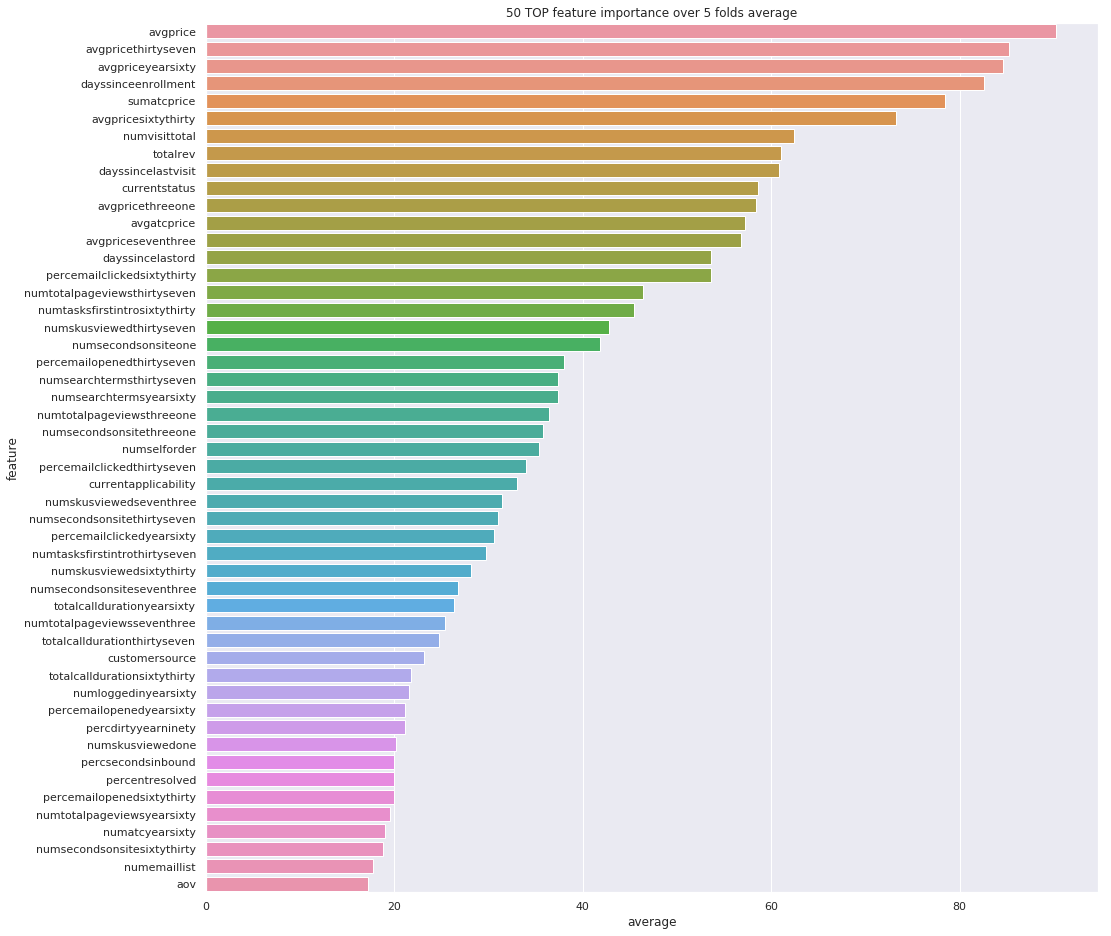

In [33]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('lgmfeature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [34]:

folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances2 = pd.DataFrame()
feature_importances2['feature'] = X_final.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_final, y_final)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = xgb.DMatrix(X_final.iloc[trn_idx], label=y_final.iloc[trn_idx])
    val_data = xgb.DMatrix(X_final.iloc[test_idx], label=y_final.iloc[test_idx])
    clf2 = xgb.train(best_parameters, trn_data, 10000, evals=[(val_data,'valid'), (trn_data,'train')], 
                     verbose_eval=1000, early_stopping_rounds=500)
    
    #feature_importances2['fold_{}'.format(fold + 1)] = list(clf2.get_score(importance_type='weight').values())
    aucs.append(clf2.best_score)
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
[0]	valid-auc:0.667156	train-auc:0.590447
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 500 rounds.
[1000]	valid-auc:0.772987	train-auc:0.764857
Stopping. Best iteration:
[636]	valid-auc:0.772987	train-auc:0.764857

Fold 1 finished in 0:00:53.978542
Training on fold 2
[0]	valid-auc:0.629397	train-auc:0.66222
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 500 rounds.
[1000]	valid-auc:0.76244	train-auc:0.799105
Stopping. Best iteration:
[1232]	valid-auc:0.763924	train-auc:0.801932

Fold 2 finished in 0:03:06.711746
Training on fold 3
[0]	valid-auc:0.712335	train-auc:0.707379
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 500 rounds.
[1000]	valid-auc:0.8143	train-auc:0.807852
[2000]	valid-auc:0.814009	train-auc:0.80959

<Figure size 1152x1152 with 0 Axes>

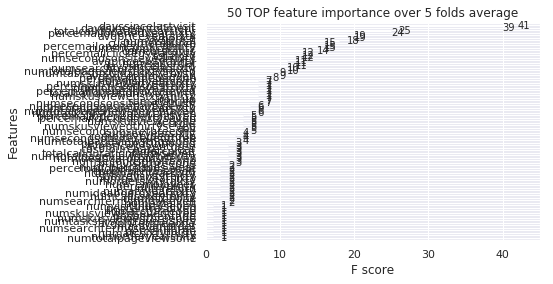

In [35]:
#feature_importances2['average'] = feature_importances2[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#feature_importances2.to_csv('xgmfeature_importances.csv')
plt.figure(figsize=(16, 16))
#sns.barplot(data=feature_importances2.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
xgb.plot_importance(clf2)
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [47]:
from catboost import CatBoostClassifier, Pool
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances3 = pd.DataFrame()
feature_importances3['feature'] = X_final.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X_final, y_final)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = Pool(X_final.iloc[trn_idx], label=y_final.iloc[trn_idx])
    val_data = Pool(X_final.iloc[test_idx], label=y_final.iloc[test_idx])
    model = CatBoostClassifier(learning_rate=0.03,
                           eval_metric='AUC')

    model.fit(X_final.iloc[trn_idx],y_final.iloc[trn_idx],eval_set=val_data, verbose_eval=1000, early_stopping_rounds=500)
    print(model.get_best_score())


Training on fold 1
0:	test: 0.6186705	best: 0.6186705 (0)	total: 99.1ms	remaining: 1m 38s
999:	test: 0.7930828	best: 0.7962868 (642)	total: 1m 31s	remaining: 0us

bestTest = 0.7962868158
bestIteration = 642

Shrink model to first 643 iterations.
{'learn': {'Logloss': 0.26477285634358466}, 'validation': {'Logloss': 0.32741386709340625, 'AUC': 0.7962868157767407}}
Training on fold 2
0:	test: 0.6725828	best: 0.6725828 (0)	total: 225ms	remaining: 3m 45s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.766621825
bestIteration = 298

Shrink model to first 299 iterations.
{'learn': {'Logloss': 0.28816516045419016}, 'validation': {'Logloss': 0.34438630920482466, 'AUC': 0.7666218250414436}}
Training on fold 3
0:	test: 0.7292323	best: 0.7292323 (0)	total: 170ms	remaining: 2m 49s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8197957665
bestIteration = 336

Shrink model to first 337 iterations.
{'learn': {'Logloss': 0.3027513008158614}, 'validation': {'Lo

Final light

In [50]:
best_iter = clf.best_iteration
clff = lgb.LGBMClassifier(**best_parameters1, num_boost_round=best_iter)
clff.fit(X_final, y_final)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.9536963213201116, bagging_freq=12,
               boosting_type='gbdt', cat_smooth=34, class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.9792648938446394,
               importance_type='split', lambda_l1=25.201509732876225,
               lambda_l2=4, learning_rate=0.054004890969923114, max_depth=9,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=23, min_split_gain=0.0, n_estimators=94,
               n_jobs=-1, nthread=-1, num_boost_round=94, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, seed=224, silent=True, subsample=1.0,
               subsample_for_bin=200000, ...)

In [75]:
sub = pd.read_csv(data_dir + 'df_holdout_scholarjet.csv',index_col = 0)
test.fillna(-999, inplace=True)
sub['convert_30'] = clff.predict(test)

In [79]:
answer1 = sub[['cuid','convert_30']]

In [83]:
answer1.to_csv('light.csv')


0    30109
1      266
Name: convert_30, dtype: int64